In [1]:
%matplotlib notebook

In [2]:
import warnings; warnings.simplefilter('ignore')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.signal as signal
import ipywidgets as widgets
from IPython.display import display
sns.set_context('talk')

<hr>

# Signal Processing for Data Scientists

Jed Ludlow

Savvysherpa, Inc.

<hr>

Get the code at https://github.com/jedludlow/sp-for-ds

## Overview

* Signal processing: Tools to separate the useful information from the nuisance information in a time series.
* Cover three areas today
  * Fourier analysis in the frequency domain
  * Discrete-time sampling
  * Digital filtering

# Fourier Analysis in the Frequency Domain

## Fourier Series

A periodic signal $s(t)$ can be expressed as a (possibly infininte) sum of simple sinusoids. Usually we approximate it by truncating the series to $N$ terms as

$$s_N(t) = \frac{A_0}{2} + \sum_{n=1}^N A_n \sin(\tfrac{2\pi nt}{P}+\phi_n) \quad \scriptstyle \text{for integer}\ N\ \ge\ 1$$

## Discrete Fourier Transform

If we have a short sample of a periodic signal, the discrete Fourier transform allows us to recover its sinusoidal frequency components. Numerically, the problem of computing the discrete Fourier transform has been studied for many years, and the result is the Fast Fourier Transform (FFT).

>In 1994, Gilbert Strang described the FFT as "the most important numerical algorithm of our lifetime" and it was included in Top 10 Algorithms of 20th Century by the IEEE journal Computing in Science & Engineering. (source: https://en.wikipedia.org/wiki/Fast_Fourier_transform)

In Python, this transform is available in the `numpy.fft` package.

In [4]:
def fft_scaled(x, axis=-1, samp_freq=1.0, remove_mean=True):
    """
    Fully scaled and folded FFT with physical amplitudes preserved.

    Arguments
    ---------

    x: numpy n-d array
        array of signal information.

    axis: int
        array axis along which to compute the FFT.

    samp_freq: float
        signal sampling frequency in Hz.

    remove_mean: boolean
        remove the mean of each signal prior to taking the FFT so the DC
        component of the FFT will be zero.

    Returns
    --------

    (fft_x, freq) where *fft_x* is the full complex FFT, scaled and folded
    so that only positive frequencies remain, and *freq* is a matching
    array of positive frequencies.

    Examples
    --------

    A common use case would present the signals in a 2-D array
    where each row contains a signal trace. Columns would
    then represent time sample intervals of the signals. The rows of
    the returned *fft_x* array would contain the FFT of each signal, and
    each column would correspond to an entry in the *freq* array.

    """
    # Get length of the requested array axis.
    n = x.shape[axis]

    # Use truncating division here since for odd n we want to
    # round down to the next closest integer. See docs for numpy fft.
    half_n = n // 2

    # Remove the mean if requested
    if remove_mean:
        ind = [slice(None)] * x.ndim
        ind[axis] = np.newaxis
        x = x - x.mean(axis)[ind]

    # Compute fft, scale, and fold negative frequencies into positive.
    def scale_and_fold(x):
        # Scale by length of original signal
        x = (1.0 / n) * x[:half_n + 1]
        # Fold negative frequency
        x[1:] *= 2.0
        return x

    fft_x = np.fft.fft(x, axis=axis)
    fft_x = np.apply_along_axis(scale_and_fold, axis, fft_x)

    # Matching frequency array. The abs takes care of the case where n
    # is even, and the Nyquist frequency is usually negative.
    freq = np.fft.fftfreq(n, 1.0 / samp_freq)
    freq = np.abs(freq[:half_n + 1])

    return (fft_x, freq)

## 1 Hz Square Wave

<IPython.core.display.Javascript object>


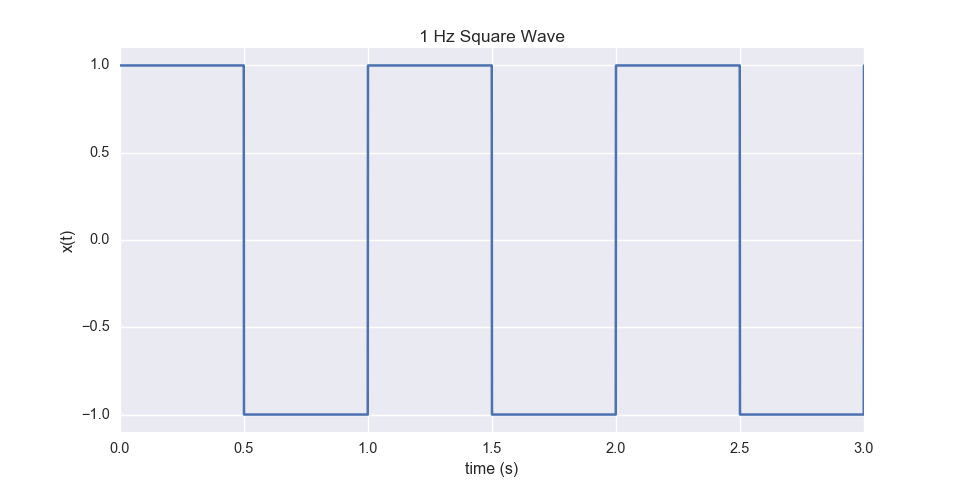

In [5]:
f_s = 1000.0  # Sampling frequency in Hz
time = np.arange(0.0, 100.0 + 1.0/f_s, 1.0/f_s)
square_wave = signal.square(2 * np.pi * time)
plt.figure(figsize=(12, 6))
plt.plot(time, square_wave), plt.xlabel('time (s)'), plt.ylabel('x(t)'), plt.title('1 Hz Square Wave')
plt.xlim((0, 3)), plt.ylim((-1.1, 1.1));

## Fourier Analysis of Square Wave

<IPython.core.display.Javascript object>


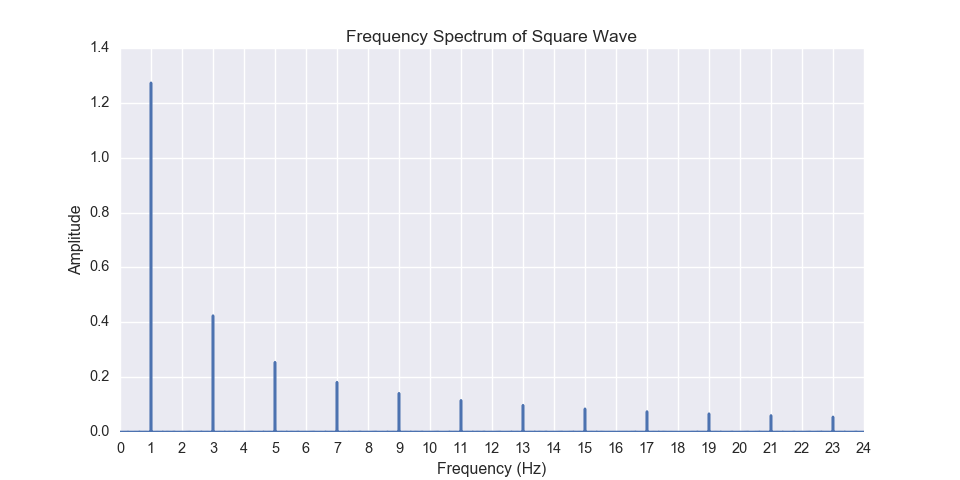

In [6]:
fft_x, freq_sq = fft_scaled(square_wave, samp_freq=f_s)
f_max = 24.0
plt.figure(figsize=(12, 6)), plt.plot(freq_sq, np.abs(fft_x))
plt.xticks(np.arange(0.0, f_max + 1.0, 1.0))
plt.xlim((0, f_max)), plt.xlabel('Frequency (Hz)'), plt.ylabel('Amplitude')
plt.title('Frequency Spectrum of Square Wave');

## Approximate 1 Hz Square Wave

Let's sythesize an approximation to a square wave by summing a reduced number of sinusoidal components.

In [7]:
# Set frequency components and amplitudes.
# Square waves contain all the odd harmonics
# of the fundamental frequency.
f_components = [1.0, 3.0, 5.0, 7.0, 9.0, 11.0]
# f_components = [1.0, 3.0, 5.0, 7.0, 9.0, 11.0,
#                 13.0, 15.0, 17.0, 19.0, 21.0]
amplitudes = [1.28 / f for f in f_components]

# Generate the square wave
s_t = np.zeros_like(time)
for f, amp in zip(f_components, amplitudes):
    s_t += amp * np.sin(2 * np.pi * f * time)

<IPython.core.display.Javascript object>


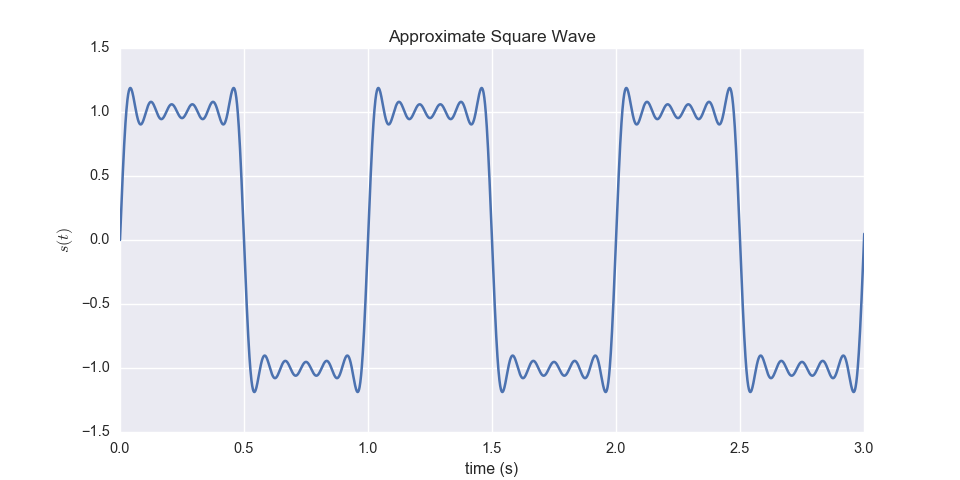

In [8]:
plt.figure(figsize=(12, 6)), plt.plot(time, s_t)
plt.xlabel('time (s)'), plt.ylabel('$s(t)$'), plt.xlim((0, 3))
plt.title('Approximate Square Wave');

## Fourier Analysis of Approximate Square Wave

<IPython.core.display.Javascript object>


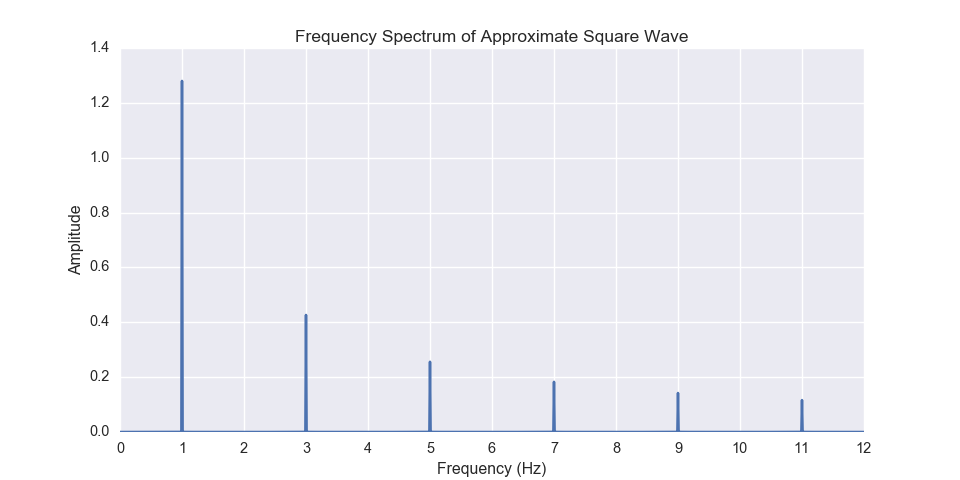

In [9]:
freq_spec, freq = fft_scaled(s_t, samp_freq=f_s)
f_max = 12.0
plt.figure(figsize=(12, 6)), plt.plot(freq, np.abs(freq_spec))
plt.xticks(np.arange(0.0, f_max + 1.0, 1.0))
plt.xlim((0, f_max)), plt.xlabel('Frequency (Hz)'), plt.ylabel('Amplitude')
plt.title('Frequency Spectrum of Approximate Square Wave');

# Discrete-Time Sampling

## Nyquist-Shannon Sampling Theorem

Consider a continuous signal $x(t)$ with Fourier transfom $X(f)$. Assume:

* A sampled version of the signal is constructed as

$$x_k = x(kT), k \in \mathbb{I}$$

* $x(t)$ is band-limited such that

$$X(f) = 0 \ \forall \ |f| > B$$

<center><img src="images/Bandlimited.svg" width="300"></center>

Then $x(t)$ is uniquely recoverable from $x_k$ if

$$\frac{1}{T} \triangleq f_s > 2B$$

This critical frequency shows up so frequently that is has its own name, the Nyquist frequency.

$$f_N = \frac{f_s}{2}$$

*A note about frequency:* Most theoretical signal processing work is done using circular frequency $\omega$ in units of rad/sec. This is done to eliminate the factor of of $2 \pi$ which shows up in many equations when true ordinary frequency $f$ is used. That said, nearly all practical signal processing is done with ordinary frequency. The relationship between the two frequencies is

$$ \omega = 2 \pi f$$

<center><img src="images/ideal_sampler.png" width="800"></center>
image credit: MIT Open Courseware, Signals and Systems, Oppenheimer

## Practical Realities

* For complete recoverability, Nyquist requires an *ideal sampler* and an *ideal interpolator*. In practice, these are not physically realizable.

$$x(t) = \mathrm{IdealInterpolator}_T(\mathrm{IdealSampler}_T(x(t))$$

* Real signals are never perfectly band-limited. There are always some noise components out past the Nyquist sampling rate. 

* You will often be given sampled data but have very little insight into the system that generated the data. In that situation, you really have *no* guarantees that any estimates of frequency content for the underlying continuous time process are correct. You may be observing alias frequencies. A frequency $f_a$ is an alias of $f$ if

$$ f_a = |nf_s - f|, n \in \mathbb{I}$$


## Aliasing

When your signal contains frequency components that are above the Nyquist frequency then those high frequency components show up at lower frequencies. These lower frequencies are called *aliases* of the higher frequencies.

In [10]:
def scale_and_fold(x):
    n = len(x)
    half_n = n // 2
    # Scale by length of original signal
    x = (1.0 / n) * x[:half_n + 1]
    # Fold negative frequency
    x[1:] *= 2.0
    return x

In [11]:
def aliasing_demo():
    f_c = 1000.0  # Hz
    f_s = 20.0  # Hz
    f_end = 25.0  # Hz
    f = 1.0  # Hz

    time_c = np.arange(0.0, 10.0 + 1.0/f_c, 1/f_c)
    time_s = np.arange(0.0, 10.0 + 1.0/f_s, 1/f_s)
    freq_c = np.fft.fftfreq(len(time_c), 1.0 / f_c)
    freq_c = np.abs(freq_c[:len(time_c) // 2 + 1])
    freq_s = np.fft.fftfreq(len(time_s), 1.0 / f_s)
    freq_s = np.abs(freq_s[:len(time_s) // 2 + 1])

    f=widgets.FloatSlider(value=1.0, min=0.0, max=f_end, step=0.1, description='Frequency (Hz)')
    phi = widgets.FloatSlider(value=0.0, min=0.0, max=2.0*np.pi, step=0.1, description="Phase (rad)")

    x_c = np.sin(2 * np.pi * f.value * time_c + phi.value)
    x_s = np.sin(2 * np.pi * f.value * time_s + phi.value)
    fig, ax = plt.subplots(2, 1, figsize=(12,7))
    fig.subplots_adjust(hspace=0.3)
    line1 = ax[0].plot(time_c, x_c, alpha=0.9, lw=2.0)[0]
    line2 = ax[0].plot(time_s, x_s, marker='o', color='r', ls=':')[0]
    ax[0].set_xlabel("Time (s)")
    ax[0].set_ylabel("$x$")
    ax[0].set_title('Sine Wave Sampled at {} Hz'.format(int(f_s)))
    ax[0].set_ylim((-1, 1))
    ax[0].set_xlim((0, 1))

    window_c = 2 * np.hanning(len(time_c))
    window_s = 2 * np.hanning(len(time_s))
    fft_c = scale_and_fold(np.fft.fft(x_c * window_c))
    fft_s = scale_and_fold(np.fft.fft(x_s * window_s))

    line3 = ax[1].plot(freq_c, np.abs(fft_c), alpha=0.5, lw=2)[0]
    line4 = ax[1].plot(freq_s, np.abs(fft_s), 'r:', lw=2)[0]
    line5 = ax[1].axvline(f_s / 2.0, color='0.75', ls='--')
    plt.axvline(f_s, color='0.75')
    ax[1].text(1.02 * f_s / 2, 0.93, '$f_N$', {'size':14})
    ax[1].text(1.01 * f_s, 0.93, '$f_s$', {'size':14})
    ax[1].set_xlabel("Frequency (Hz)")
    ax[1].set_ylabel("$X(f)$")
    ax[1].set_xlim((0, f_end))

    def on_slider(s):  
        x_c = np.sin(2 * np.pi * f.value * time_c + phi.value)
        x_s = np.sin(2 * np.pi * f.value * time_s + phi.value)
        fft_c = scale_and_fold(np.fft.fft(x_c * window_c))
        fft_s = scale_and_fold(np.fft.fft(x_s * window_s))

    #     line1.set_xdata(time_c)
        line1.set_ydata(x_c)
    #     line2.set_xdata(time_s)
        line2.set_ydata(x_s)
        line3.set_ydata(np.abs(fft_c))
        line4.set_ydata(np.abs(fft_s))
        plt.draw()

    f.on_trait_change(on_slider)
    phi.on_trait_change(on_slider)

    display(f)
    display(phi)

<IPython.core.display.Javascript object>


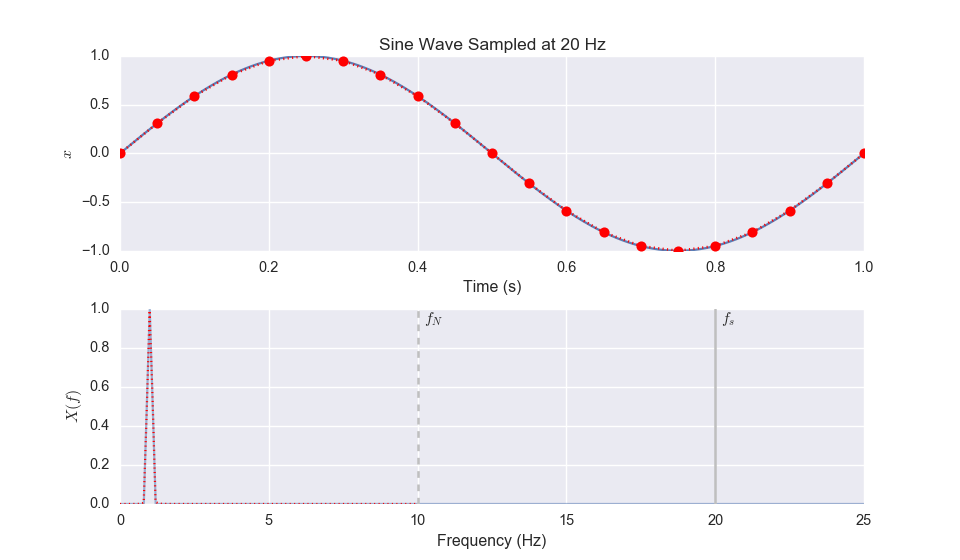

The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


In [12]:
aliasing_demo()

## Avoiding Aliasing

If you have control over the sampling process, specify a sampling frequency that is at least twice the highest frequency component of your signal. If you really want to preserve high fidelity, specify a sampling frequency that is ten times the highest frequency component in your signal.

# Digital Filtering

## Reshaping the Signal

So far we've discussed analysis techniques for characterizing the frequency content of a signal. Now we discuss how to modify the frequency content of the signal to emphasize some of the information in it while removing other aspects. Generally accomplish this using digital filters.

## Moving Average as a Digital Filter

Let's express a moving average of five in the language of digital filtering. The output $y$ the $k$-th sample is a function of the last five inputs $x$.

$$y_k = \frac{x_k + x_{k-1} + x_{k-2} + x_{k-3} + x_{k-4}}{5}$$

More generally, this looks like

$$y_k = b_0 x_k + b_1 x_{k-1} + b_2 x_{k-2} + b_3 x_{k-3} + b_4 x_{k-4}$$

where all the $b_i = 0.2$. But they don't have to be equal. We could select each of the $b_i$ independently to be whatever we want. Then the filter looks like a weighted average.

## Using Previous Outputs

Even more generally, the current output can be a function of previous *outputs* as well as inputs if we desire.

$$y_k = \frac{1}{a_0} \left(\frac{b_0 x_k + b_1 x_{k-1} + b_2 x_{k-2} + b_3 x_{k-3} + b_4 x_{k-4}, + \cdots}
             {a_1 y_{k-1} + a_2 y_{k-2} + a_3 y_{k-3} + a_4 y_{k-4} + \cdots}
             \right)$$
             
But how do we choose the $b_i$ and the $a_i$ to get a filter with a particular desired behavior?

## Standard Digital Filter Designs

Luckily, standard filter designs already exist to create filters that have certain response characteristics, either in the time domain or the frequency domain.

* Butterworth
* Chebyshev
* Elliptic
* Bessel

When in doubt, use the Butterworth filter since it's a great general purpose filter and is easier to specify. All of these filter designs are available in `scipy.signal`.

In [13]:
def butter_filt(x, sampling_freq_hz, corner_freq_hz=4.0, lowpass=True, filtfilt=False):
    """
    Smooth data with a low-pass or high-pass filter.

    Apply a 2nd order Butterworth filter. Note that if filtfilt
    is True the applied filter is effectively a 4th order Butterworth.
    
    Parameters
    ----------
    x: 1D numpy array
        Array containing the signal to be smoothed.
    sampling_freq_hz: float
        Sampling frequency of the signal in Hz.
    corner_freq_hz: float
        Corner frequency of the Butterworth filter in Hz.
    lowpass: bool
        If True (default), apply a low-pass filter. If False,
        apply a high-pass filter.
    filtfilt: bool
        If True, apply the filter forward and then backward
        to elminate delay. If False (default), apply the
        filter only in the forward direction.

    Returns
    -------
    filtered: 1D numpy array
        Array containing smoothed signal
    b, a: 1D numpy arrays
        Polynomial coefficients of the smoothing filter as returned from
        the Butterworth design function.

    """
    nyquist = sampling_freq_hz / 2.0
    f_c = np.array([corner_freq_hz, ], dtype=np.float64)  # Hz
    # Normalize by Nyquist
    f_c /= nyquist
    # Second order Butterworth filter at corner frequency
    btype = 'low' if lowpass else 'high'
    b, a = signal.butter(2, f_c, btype=btype)
    # Apply the filter either in forward direction or forward-back.
    if filtfilt:
        filtered = signal.filtfilt(b, a, x)
    else:
        filtered = signal.lfilter(b, a, x)
    return (filtered, b, a)

<IPython.core.display.Javascript object>


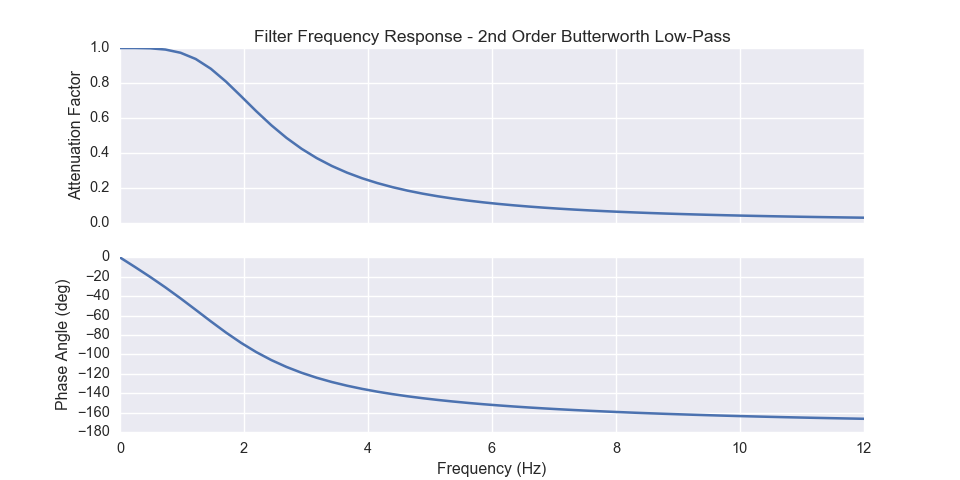

In [14]:
f_c_low = 2.0  # Corner frequency in Hz
s_filtered, b, a = butter_filt(s_t, f_s, f_c_low)
w, h = signal.freqz(b, a, 2048)
w *= (f_s / (2 * np.pi))
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
ax[0].plot(w, abs(h)), plt.xlim((0, 12)), ax[1].plot(w, np.angle(h, deg=True))
ax[0].set_ylabel('Attenuation Factor'), ax[1].set_ylabel('Phase Angle (deg)')
ax[1].set_xlabel('Frequency (Hz)')
ax[0].set_title('Filter Frequency Response - 2nd Order Butterworth Low-Pass');

<IPython.core.display.Javascript object>


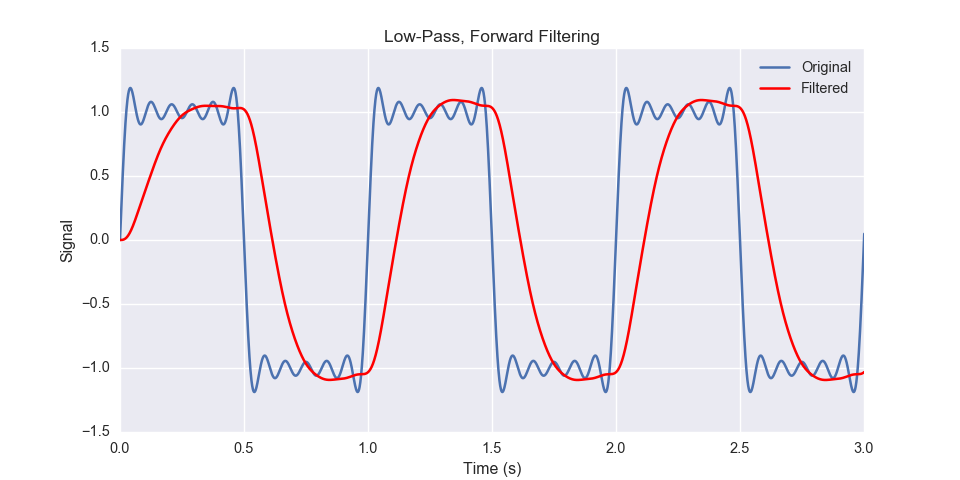

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(time, s_t, label='Original'), plt.plot(time, s_filtered, 'r-', label='Filtered')
plt.xlim((0, 3))
plt.xlabel('Time (s)'), plt.ylabel('Signal'), plt.legend(), plt.title('Low-Pass, Forward Filtering');

<IPython.core.display.Javascript object>


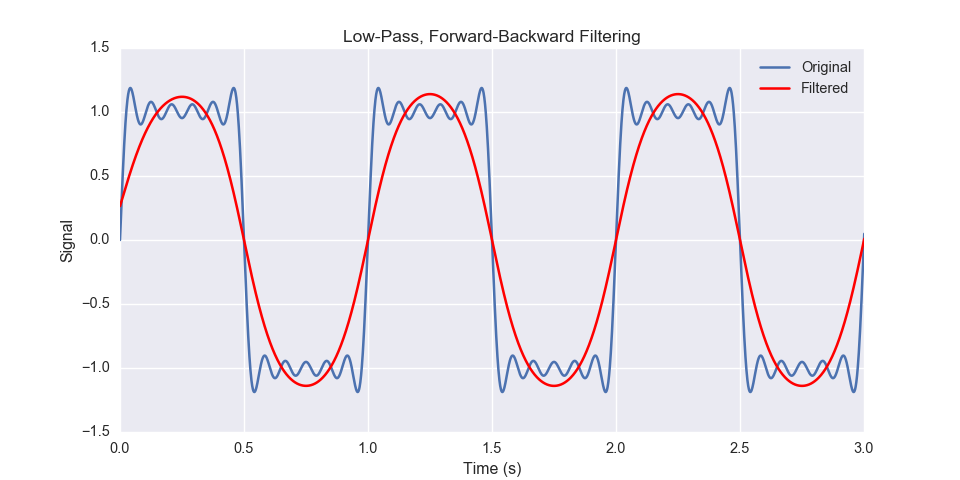

In [16]:
s_filtered, b, a = butter_filt(s_t, f_s, f_c_low, filtfilt=True)
plt.figure(figsize=(12, 6))
plt.plot(time, s_t, label='Original'), plt.plot(time, s_filtered, 'r-', label='Filtered')
plt.xlim((0, 3))
plt.xlabel('Time (s)'), plt.ylabel('Signal'), plt.legend(), plt.title('Low-Pass, Forward-Backward Filtering');

<IPython.core.display.Javascript object>


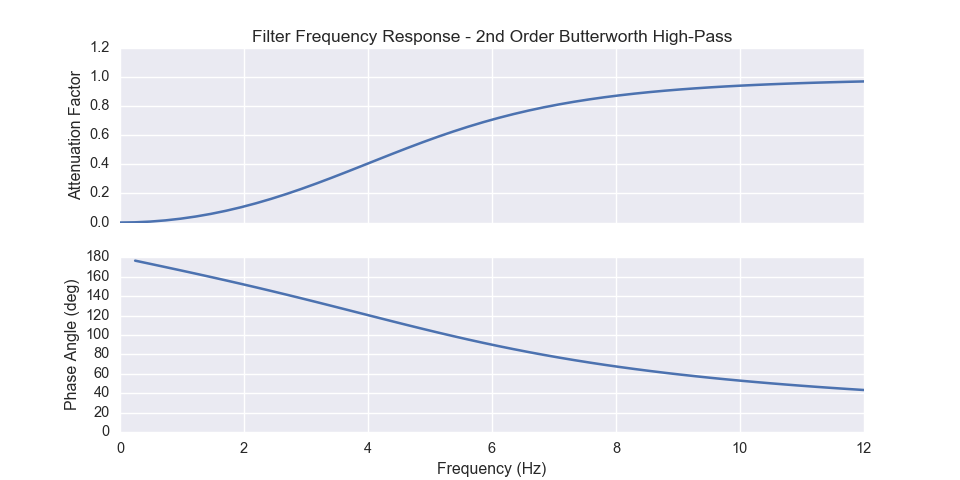

In [17]:
f_c_high = 6.0  # Corner frequency in Hz
s_filtered, b, a = butter_filt(s_t, f_s, f_c_high, lowpass=False, filtfilt=True)
w, h = signal.freqz(b, a, 2048)
w *= (f_s / (2 * np.pi))
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
ax[0].plot(w, abs(h)), plt.xlim((0, 12)), ax[1].plot(w[1:], np.angle(h, deg=True)[1:])
ax[0].set_ylabel('Attenuation Factor'), ax[1].set_ylabel('Phase Angle (deg)')
ax[1].set_xlabel('Frequency (Hz)')
ax[0].set_title('Filter Frequency Response - 2nd Order Butterworth High-Pass');

<IPython.core.display.Javascript object>


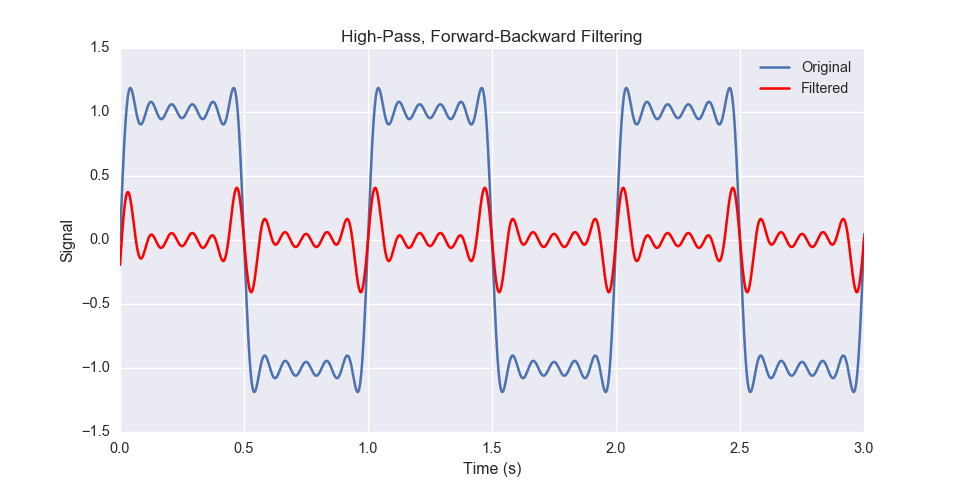

In [18]:
s_filtered, b, a = butter_filt(s_t, f_s, f_c_high, lowpass=False, filtfilt=True)
plt.figure(figsize=(12, 6))
plt.plot(time, s_t, label='Original'), plt.plot(time, s_filtered, 'r-', label='Filtered')
plt.xlim((0, 3))
plt.xlabel('Time (s)'), plt.ylabel('Signal'), plt.legend(), plt.title('High-Pass, Forward-Backward Filtering');

# Thank you!